In [5]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
import sklearn.datasets
import matplotlib.tri as tri
from scipy.special import betaln
from scipy.stats import beta, norm
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)


from deep_bayes.models import DeepEvidentialModel
from deep_bayes.settings import EVIDENTIAL_BF
from deep_bayes.training import train_online
from deep_bayes.losses import log_loss
from deep_bayes.diagnostics import accuracy, expected_calibration_error
from deep_bayes.viz import plot_model_samples, plot_confusion_matrix

1.15.0


In [6]:
%load_ext autoreload
%autoreload 2

tf.enable_eager_execution()

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


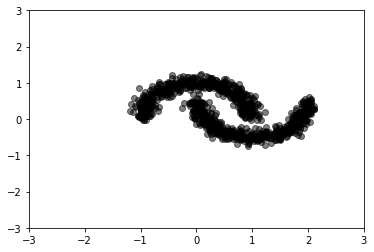

In [7]:
noise = 0.1
samples, label = sklearn.datasets.make_moons(n_samples=1000, shuffle=False, noise=noise)
x = samples[:,0]
y = samples[:, 1]
colors = (0,0,0)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.scatter(x, y, c=colors, alpha=0.5)


In [8]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

In [9]:
def moonA(n_samples):
    x, y = sklearn.datasets.make_moons(n_samples=2*n_samples, shuffle=False, noise=noise)
    return x[0:n_samples]

def moonB(n_samples):
    x, y = sklearn.datasets.make_moons(n_samples=2*n_samples, shuffle=False, noise=noise)
    return x[n_samples:]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(100, 2)


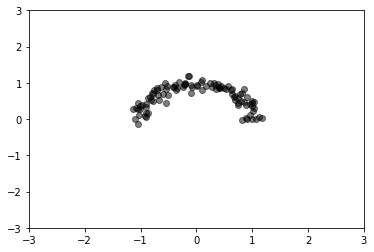

In [10]:
a = moonA(100)
print(a.shape)
x = a[:,0]
y = a[:, 1]
colors = (0,0,0)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.scatter(x, y, c=colors, alpha=0.5)

In [11]:
def data_generator(batch_size, model_prior, forward_models, alpha_smooth=None,
                   n_obs=None, n_obs_min=100, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    n_obs = 100
    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](n_obs)
        # Store data and params
        x.append(x_m.reshape(-1, 2))
#         theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Apply label smoothing, if specified
    if alpha_smooth is not None:
        m = m * (1 - alpha_smooth) + alpha_smooth / n_models    
    # Convert to tensor, if specified 
    if to_tensor:
#         theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
#     print(x.shape)    
    return {'m': m, 'x': x}

In [18]:
#--- Training hyperparameters ---#
n_obs = 1000
n_test = 500
n_cal = 5000
alpha_smooth = None
epochs = 50
iterations_per_epoch = 100


batch_size = 64
ckpt_file = 'toy_two_moons_test'

#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.001
decay_steps = 100
decay_rate = .95

#--- Data generation ---#
# model_names = ['Model 1', 'Model 2']
# param_priors = [beta_wide_prior, beta_sharp_prior]
forward_models = [moonA, moonB]
data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   forward_models=forward_models,
                   n_obs=n_obs,
                   alpha_smooth=alpha_smooth)


# --- Optimizer --- #
global_step = tf.Variable(0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [19]:
model = DeepEvidentialModel(EVIDENTIAL_BF)

In [20]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [21]:
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=partial(log_loss, lambd=1), 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              global_step=global_step,
                              method='evidence')
        manager.save()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: 

## Testing


In [ ]:
batch_size = 1

n_obs = 200

n_models = len(forward_models)
m_indices = model_prior(batch_size, n_models)
  
# Sample N, if not specified
if n_obs is None:
    n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)

# For each model index, sample from prior and run generative model.
x = []

for m_idx in m_indices:

    # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
    x_m = np.random.normal(2, 1, n_obs)
    # Store data and params
    x.append(x_m.reshape(-1, 1))
#         theta.append(theta_m)

# One-hot encode model indices
m = to_categorical(m_indices, num_classes=n_models)


x = tf.convert_to_tensor(x, dtype=tf.float32)






# x = data_gen(1)
print(x.shape)
a = model.predict(x, to_numpy=True)
print(a)
# a['alpha'][0][0] = 2

(1000000, 2)
(1000000, 1, 2)
(1000000, 1, 2)
(1000000, 2)
(1000000,)


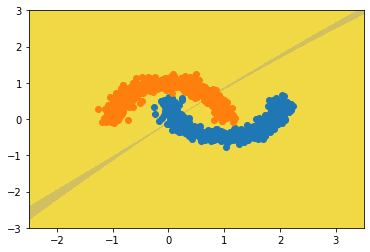

In [22]:
domain = 3
x_lin = np.linspace(-domain+0.5, domain+0.5, 1000)
y_lin = np.linspace(-domain, domain, 1000)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=1000, noise=noise)
mask = y_vis.astype(np.bool)

# with torch.no_grad():
print(X_grid.shape)
T = np.expand_dims(X_grid, axis=1)
print(T.shape)


T = tf.convert_to_tensor(T, dtype=tf.float32)

print(T.shape)
a = model.predict(T, to_numpy=True)
print(a['m_probs'].shape)
confidence = a['m_probs'].max(1)
print(confidence.shape)
# output = model.predict(tf.convert_to_tensor(T, dtype=tf.float32))
# print(output)
#     confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1])
plt.scatter(X_vis[~mask,0], X_vis[~mask,1])

In [ ]:
T = np.array([-2, 1]).reshape(1, -1)
# print(T.shape)
T = tf.convert_to_tensor(np.expand_dims(T, axis=1), dtype=tf.float32)
print(T.shape)
# print(T.shape)
a = model.predict(T, to_numpy=True)
print(a)